# Test BBRv3 patches

The goal of this experiment is to test the improvement from BBRv1 to BBRv3.

## Experimental environment

### Hardware environment

BBRv3 will be tested on Azure using `Standard_D2s_v5` node.
There will two VMs located in eastus2 and westeurope and connected each other through virtual network.

### Software environment

The Azure node runs Mariner in the following version:

```
NAME="Microsoft Azure Linux"
VERSION="3.0.20240727"
ID=azurelinux
VERSION_ID="3.0"
PRETTY_NAME="Microsoft Azure Linux 3.0"
ANSI_COLOR="1;34"
HOME_URL="https://aka.ms/azurelinux"
BUG_REPORT_URL="https://aka.ms/azurelinux"
SUPPORT_URL="https://aka.ms/azurelinux"
```

The kernel with BBRv3, *i.e.* `6.6.35.1-5.azl3.bbr3+`, patches need to be `kexec`'ed to be run, details are available in the experiment script.
Then, the network subsystem is configured as follow:

```
net.core.rmem_max = 2147483647
net.core.wmem_max = 2147483647
net.ipv4.tcp_rmem = "4096 67108864 1073741824"
net.ipv4.tcp_wmem = "4096 67108864 1073741824"
net.core.default_qdisc = fq_codel
```

## Experimental protocol

We will measure the performance of BBRv3, BBRv1 and CUBIC.
For each of this algorithm, we will run the following command 30 times:

```
iperf3 --format m --version4 --client $server_ip --port 5201 --time 30 --parallel 1 --congestion $algorithm --omit 1
```

We will measure the bandwith, in Mbit/sec, and the number of retransmitted packets, from the sender point of view.

## Hypothesis

BBRv3 should offer almost the same performance as BBRv1 but with less retransmission.

## Results

Let's compute the 99th percentile of bandwith and retransmisted packets for each algorithm:

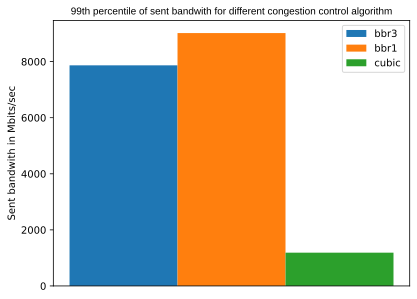

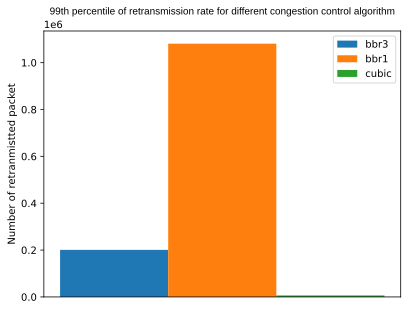

In [33]:
!pip install pandas > /dev/null
!pip install matplotlib --upgrade > /dev/null
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

ALGOS = ['bbr3', 'bbr1', 'cubic']
percentiles = {}

for algo in ALGOS:
    df = pd.read_csv(f'{algo}.out.csv')
    quantile = df[['sent', 'retrans']].quantile(0.99)
    percentiles[algo] = quantile
    
df = pd.DataFrame(percentiles)
for i, algo in enumerate(ALGOS):
    ravel = df[[algo]].to_numpy().ravel()
    plt.bar(i * 0.4, ravel[0], align='edge', width=0.4, label=algo)

plt.legend()
plt.xticks([], [])
plt.ylabel('Sent bandwith in Mbits/sec')
plt.title('99th percentile of sent bandwith for different congestion control algorithm', font='Liberation Sans')

plt.show()

for i, algo in enumerate(ALGOS):
    ravel = df[[algo]].to_numpy().ravel()
    plt.bar(i * 0.4, ravel[1], align='edge', width=-0.4, label=algo)

plt.legend()
plt.xticks([], [])
plt.ylabel('Number of retranmistted packet')
plt.title('99th percentile of retransmission rate for different congestion control algorithm', font='Liberation Sans')

plt.show()

## Conclusion

As expected, BBRv3 reduces the retransmission rate by more than 5 while reducing the bandwith by less than 15%. 